In [357]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

import nltk

from wordcloud import WordCloud

import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import proportion_difference
from mlxtend.evaluate import paired_ttest_kfold_cv
from mlxtend.evaluate import paired_ttest_resampled

In [268]:
encoding = 'ISO-8859-1'
col_names = ['target', 'text']

dataset = pd.read_csv("C:/Users/young/OneDrive/Desktop/ISR Files/training.1600000.processed.noemoticon.csv", encoding = encoding, names = col_names)

In [269]:
dataset.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [270]:
rd = dataset.copy().sample(5000, random_state=69)
rd["label"] = 0
rd = rd[['text', 'label']]
rd.dropna(inplace=True)
rd.head

<bound method NDFrame.head of                                                      text  label
26946   @bamf_xx that's a terrible way to wake up! i h...      0
222868  Just bought some used games from GameStop... I...      0
536315  Wow... just saw a Rolls Royce Phantom outside ...      0
795205  i need to get on some medication, stat. my anx...      0
405755                Is in line getting out of the expo       0
...                                                   ...    ...
12306                              the ice cream is over       0
329917         Noone wants to talk to me ... I is lonely       0
323405  hahahhahaah in claasssss! studddyyy hallll! &l...      0
581553                               visiting gram......       0
419481                         I miss theeeeeeeeeeeeeem!       0

[5000 rows x 2 columns]>

In [271]:
import pandas as pd
col_names = ['id', 'text']
rd2 = pd.read_csv("C:/Users/young/OneDrive/Desktop/ISR Files/depressive_tweets_processed.csv", sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [272]:
rd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [273]:
rd2['label'] = 1
rd2 = rd2[['text', 'label']]

In [274]:
rd2.head()

,text,label
0,The lack of this understanding is a small but ...,1
1,i just told my parents about my depression and...,1
2,depression is something i don't speak about ev...,1
3,Made myself a tortilla filled with pb&j. My de...,1
4,@WorldofOutlaws I am gonna need depression med...,1


In [275]:
rd = pd.concat([rd,rd2]) # merge the dataset on normal tweets and depressive tweets
rd = rd.sample(frac=1)  # shuffle the dataset

In [276]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7345 entries, 1471 to 2248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7313 non-null   object
 1   label   7345 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 172.1+ KB


In [277]:
rd.head()

,text,label
1471,"Depression, A Struggle Made Easier with CBD h...",1
154837,This might be old news to some people but I ju...,0
2057,92 in my uni coursework <Emoji: Smiling face w...,1
1345,Just one puff of cannabis 'could ease depressi...,1
763386,ive got hayfever for the first ever time my n...,0


In [315]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
import contractions

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = contractions.fix(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
        tweet.strip(' ' ' ')

        #stop words
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets


In [316]:
X = clean_tweets([tweet for tweet in rd['text']])

In [317]:
y = rd['label'].values

In [318]:
depressionTweets = [clean_tweets([t for t in rd2['text']])]
depressionWords = ' '.join(list(map(str, depressionTweets)))
depressionWordCloud = WordCloud(width = 512, height = 512, collocations = False, colormap="Blues").generate(depressionWords)

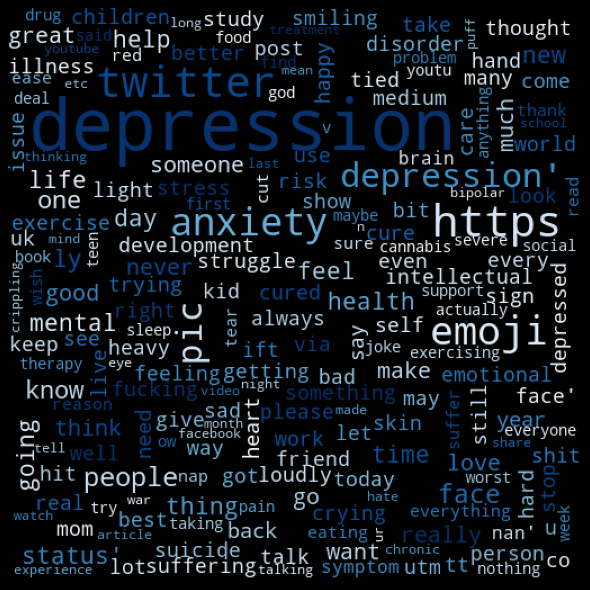

In [319]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressionWordCloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [320]:
MAX_NUM_WORDS = 100000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [321]:
word_vector = tokenizer.texts_to_sequences(X)

In [322]:
word_index = tokenizer.word_index

In [323]:
vocab_size = len(word_index)
vocab_size   # num of unique tokens

15888

In [324]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [325]:
input_tensor.shape

(7345, 140)

In [326]:
corpus = rd['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [327]:
tdidf_tensor.shape

(7345, 17090)

In [328]:
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, rd['label'].values, stratify= rd['label'].values, test_size=0.3) 

In [329]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [330]:
predictions = baseline_model.predict(x_test)

In [331]:
print(accuracy_score(y_test, predictions))
print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(f1_score(y_test, predictions))

0.9927404718693285
1.0
0.9772727272727273
0.9885057471264368


In [332]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.98945   1.00000   0.99469      1500
           1    1.00000   0.97727   0.98851       704

    accuracy                        0.99274      2204
   macro avg    0.99472   0.98864   0.99160      2204
weighted avg    0.99282   0.99274   0.99272      2204



In [333]:
x_train, x_test, y_train, y_test = train_test_split(X, rd.label, test_size=0.3, random_state = 69)

In [334]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [335]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('precision %s' % precision_score(y_pred, y_test))
print('recall %s' % recall_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test))

print(classification_report(y_test, y_pred, digits=5))

accuracy 0.911070780399274
precision 0.7391304347826086
recall 0.9695817490494296
f1 0.8388157894736842
              precision    recall  f1-score   support

           0    0.89273   0.98943   0.93860      1514
           1    0.96958   0.73913   0.83882       690

    accuracy                        0.91107      2204
   macro avg    0.93116   0.86428   0.88871      2204
weighted avg    0.91679   0.91107   0.90736      2204



In [336]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_curve

C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


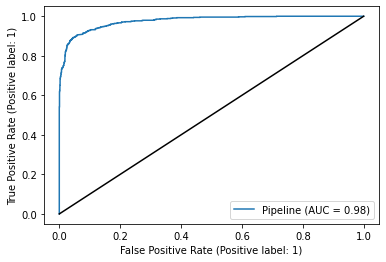

In [337]:
plot_roc_curve(nb, x_test, y_test)
plt.plot([0,1], [0,1], c='k')

C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


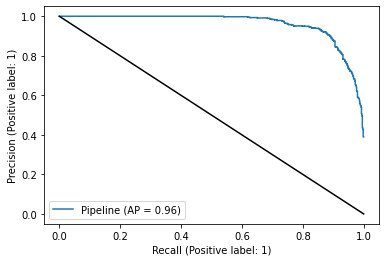

In [338]:
plot_precision_recall_curve(nb, x_test, y_test)
plt.plot([0,1], [1,0], c='k')

In [339]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=23, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=23,
                               tol=None))])

In [340]:
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('precision %s' % precision_score(y_pred, y_test))
print('recall %s' % recall_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9863883847549909
precision 0.9565217391304348
recall 1.0
f1 0.9777777777777777
              precision    recall  f1-score   support

           0    0.98057   1.00000   0.99019      1514
           1    1.00000   0.95652   0.97778       690

    accuracy                        0.98639      2204
   macro avg    0.99028   0.97826   0.98398      2204
weighted avg    0.98665   0.98639   0.98630      2204



C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


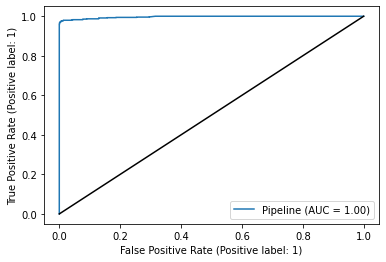

In [341]:
plot_roc_curve(sgd, x_test, y_test)
plt.plot([0,1], [0,1], c='k')

C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


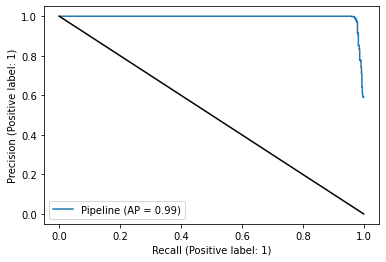

In [342]:
plot_precision_recall_curve(sgd, x_test, y_test)
plt.plot([0,1], [1,0], c='k')

In [343]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='lbfgs', max_iter=1000))])
logreg.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000))])

In [344]:
_pred = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('precision %s' % precision_score(y_pred, y_test))
print('recall %s' % recall_score(y_pred, y_test))
print('f1 %s' % f1_score(y_pred, y_test))

print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9863883847549909
precision 0.9565217391304348
recall 1.0
f1 0.9777777777777777
              precision    recall  f1-score   support

           0    0.98057   1.00000   0.99019      1514
           1    1.00000   0.95652   0.97778       690

    accuracy                        0.98639      2204
   macro avg    0.99028   0.97826   0.98398      2204
weighted avg    0.98665   0.98639   0.98630      2204



C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


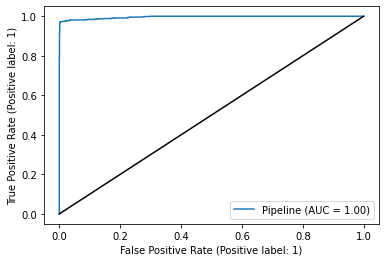

In [345]:
plot_roc_curve(logreg, x_test, y_test)
plt.plot([0,1], [0,1], c='k')

C:\Python\Python3104\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


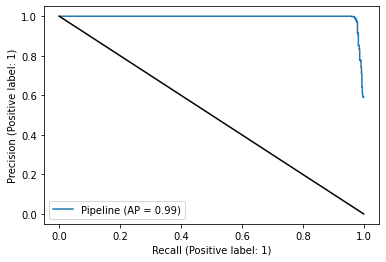

In [346]:
plot_precision_recall_curve(sgd, x_test, y_test)
plt.plot([0,1], [1,0], c='k')

In [362]:
X, y = clean_tweets([tweet for tweet in rd['text']]), rd.label
clf1 = SVC(random_state=1, probability=True)
lr = SGDClassifier(loss='hinge',class_weight='balanced')


X_train, X_test, y_train, y_test = train_test_split(tdidf_tensor, rd['label'].values, test_size = 0.3, random_state = 87)

clf1.fit(X_train, y_train)
clf2 = lr.fit(X_train, y_train)

y_pred_proba = clf1.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)


0.9984941286179058


AttributeError: probability estimates are not available for loss='hinge'